# NYC Taxi Fare Prediction

## Setup

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from statistics import mean
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from geopy import distance

## Inspection

In [2]:
taxi = pd.read_csv('train_prev.csv')        # Truncated preview
taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## Cleaning

### Pickup Datetime

In [5]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], infer_datetime_format=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### NaN Values

In [6]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

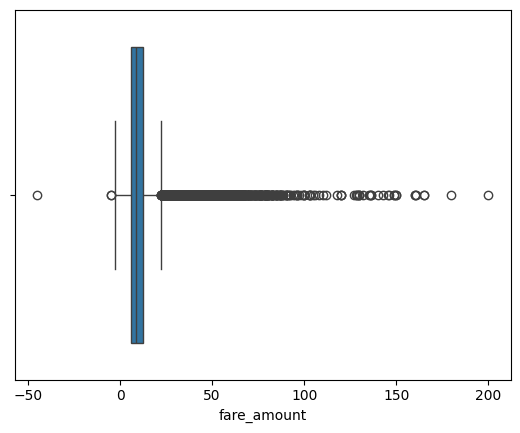

In [7]:
sns.boxplot(data=taxi, x='fare_amount')

In [8]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99991 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99991 non-null  object             
 1   fare_amount        99991 non-null  float64            
 2   pickup_datetime    99991 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99991 non-null  float64            
 4   pickup_latitude    99991 non-null  float64            
 5   dropoff_longitude  99991 non-null  float64            
 6   dropoff_latitude   99991 non-null  float64            
 7   passenger_count    99991 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

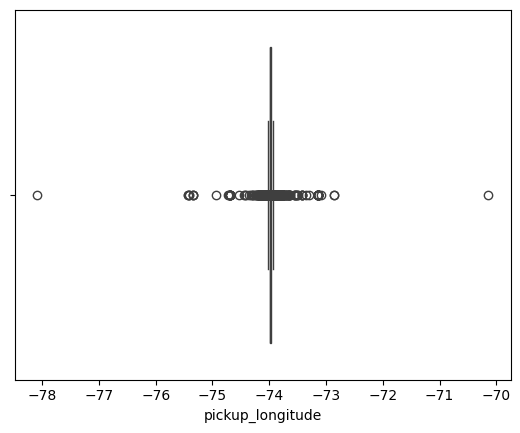

In [9]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-80, -70)], x='pickup_longitude')

In [10]:
# len(taxi.loc[~taxi['pickup_longitude'].between(-75, -73)])
taxi = taxi.loc[taxi['pickup_longitude'].between(-75, -73)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97994.000000,97994.000000,97994.000000,97994.000000,97994.000000,97994.000000
mean,11.344980,-73.975106,40.754226,-73.910252,40.724806,1.674296
std,9.690929,0.039925,1.168172,2.168744,1.609409,1.300335
min,0.000000,-74.945938,0.783332,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736638,-73.991390,40.735677,1.000000
50%,8.500000,-73.982073,40.753532,-73.980422,40.753937,1.000000
75%,12.500000,-73.968288,40.767673,-73.965046,40.768474,2.000000
max,200.000000,-73.085745,401.083332,0.000000,404.616667,6.000000


### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

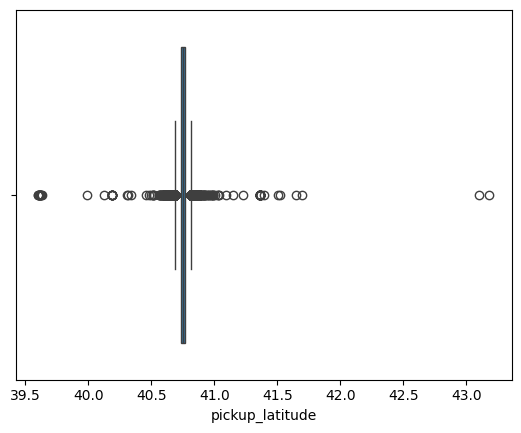

In [11]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(30, 50)], x='pickup_latitude')

In [12]:
# len(taxi.loc[~taxi['pickup_latitude'].between(40, 41)])
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 41)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97926.000000,97926.000000,97926.000000,97926.000000,97926.000000,97926.000000
mean,11.338024,-73.975425,40.750858,-73.910417,40.724619,1.674509
std,9.638646,0.036281,0.027773,2.169460,1.609887,1.300519
min,0.000000,-74.718822,40.121653,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992270,40.736635,-73.991392,40.735670,1.000000
50%,8.500000,-73.982080,40.753517,-73.980429,40.753927,1.000000
75%,12.500000,-73.968323,40.767648,-73.965087,40.768452,2.000000
max,180.000000,-73.085745,40.993260,0.000000,404.616667,6.000000


### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

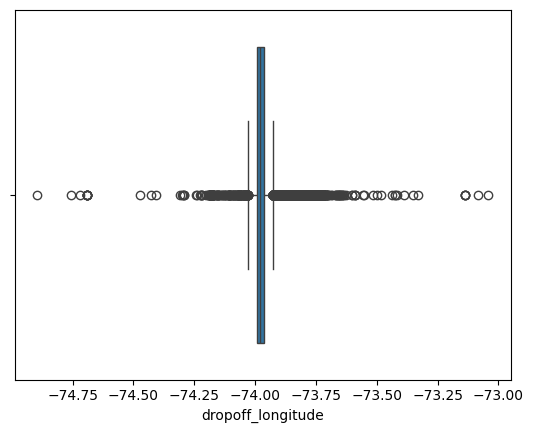

In [13]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-80, -70)], x='dropoff_longitude')

In [14]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(-75, -73)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(-75, -73)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97840.000000,97840.000000,97840.000000,97840.000000,97840.000000,97840.000000
mean,11.336845,-73.975431,40.750864,-73.974221,40.754608,1.674458
std,9.633250,0.036265,0.027767,0.036690,1.170761,1.300347
min,0.000000,-74.718822,40.121653,-74.895028,0.728087,0.000000
25%,6.000000,-73.992271,40.736635,-73.991402,40.735735,1.000000
50%,8.500000,-73.982084,40.753519,-73.980442,40.753951,1.000000
75%,12.500000,-73.968323,40.767650,-73.965153,40.768470,2.000000
max,180.000000,-73.085745,40.993260,-73.041317,404.616667,6.000000


### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

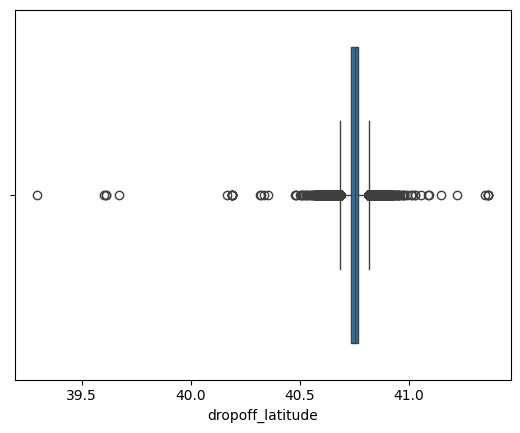

In [15]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(30, 50)], x='dropoff_latitude')

In [16]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(40, 41)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 41)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97819.000000,97819.000000,97819.000000,97819.000000,97819.000000,97819.000000
mean,11.330071,-73.975434,40.750859,-73.974263,40.751298,1.674521
std,9.594498,0.036211,0.027744,0.036014,0.031538,1.300405
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,0.000000
25%,6.000000,-73.992272,40.736639,-73.991402,40.735737,1.000000
50%,8.500000,-73.982084,40.753515,-73.980443,40.753948,1.000000
75%,12.500000,-73.968328,40.767648,-73.965161,40.768459,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


### Passenger Count

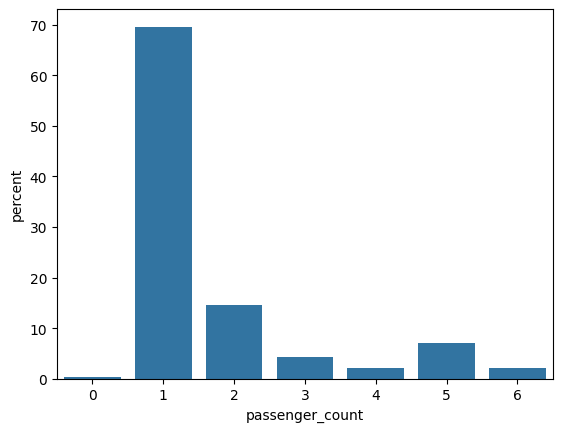

In [17]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [18]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


###

In [19]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


In [20]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97461 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                97461 non-null  object             
 1   fare_amount        97461 non-null  float64            
 2   pickup_datetime    97461 non-null  datetime64[ns, UTC]
 3   pickup_longitude   97461 non-null  float64            
 4   pickup_latitude    97461 non-null  float64            
 5   dropoff_longitude  97461 non-null  float64            
 6   dropoff_latitude   97461 non-null  float64            
 7   passenger_count    97461 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.7+ MB


## Feature Engineering

### Distance

In [21]:
taxi['distance_km'] = taxi.apply(lambda r:distance.distance((r['pickup_latitude'], r['pickup_longitude']),(r['dropoff_latitude'], r['dropoff_longitude'])).km, axis=1)
taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338


In [22]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672,3.324094
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817,3.598433
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000,0.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000,1.255759
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000,2.158052
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000,3.923854
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000,85.840891


### Time

In [114]:
taxi['pickup_hr'] = taxi.apply(lambda r: r['pickup_datetime'].hour, axis=1)
taxi['pickup_dayofweek'] = taxi.apply(lambda r: r['pickup_datetime'].dayofweek, axis=1)
taxi['pickup_dayofweek'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', }, inplace=True)
taxi['pickup_month'] = taxi.apply(lambda r: r['pickup_datetime'].month, axis=1)
taxi['pickup_year'] = taxi.apply(lambda r: r['pickup_datetime'].year, axis=1)

In [115]:
taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,multiple_passengers,pickup_hr,pickup_dayofweek,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,False,17,Mon,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,False,16,Tue,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,True,0,Thu,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,False,4,Sat,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,False,7,Tue,3,2010


## Relationships

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

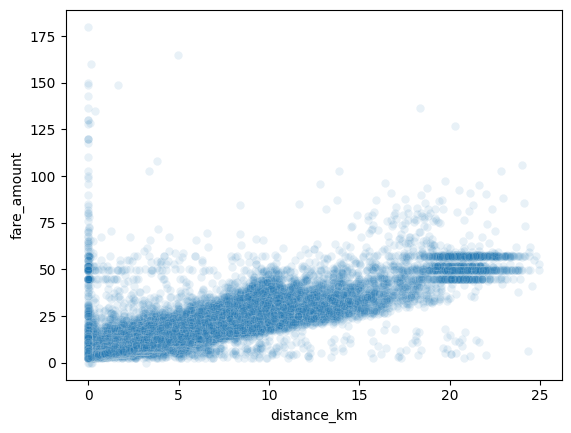

In [24]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

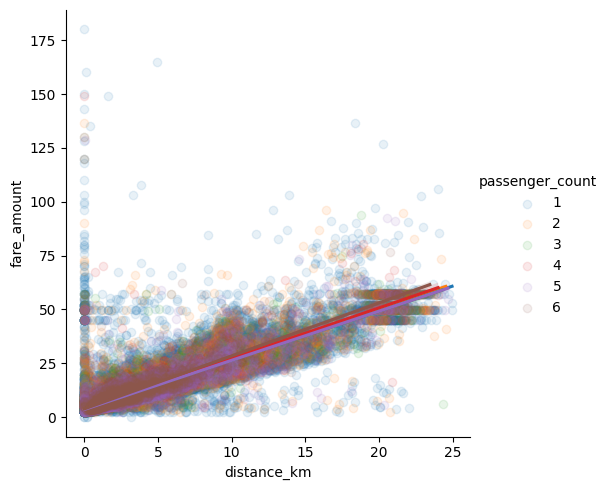

In [25]:
sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

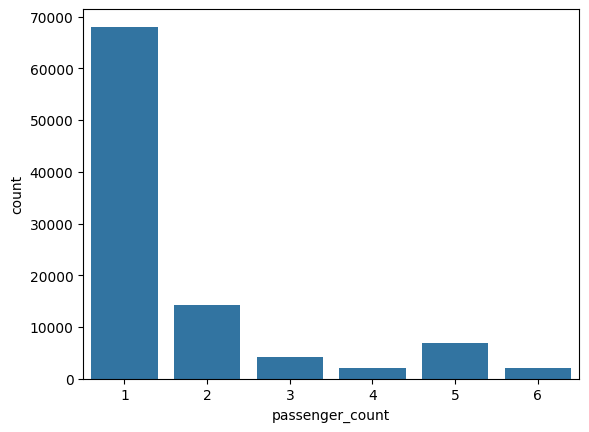

In [26]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

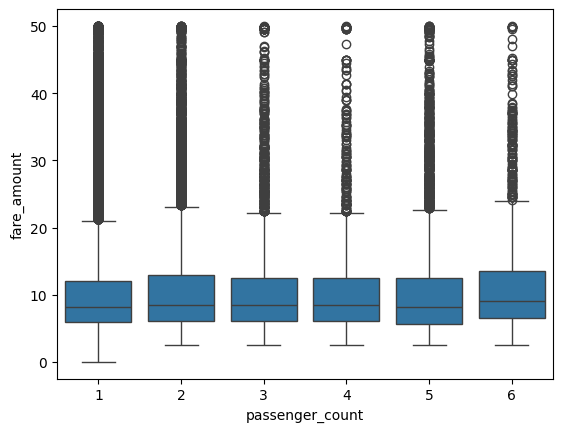

In [27]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

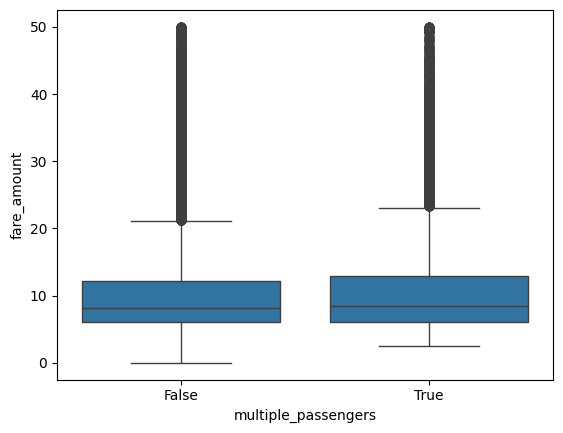

In [28]:
taxi_pass_red = taxi
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

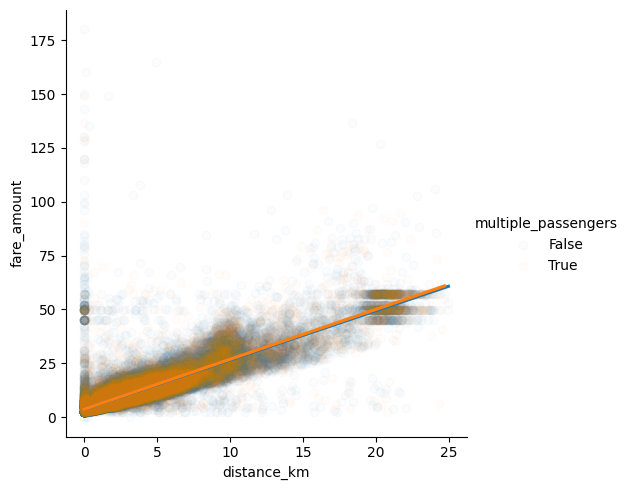

In [29]:
sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Pickup Hour')

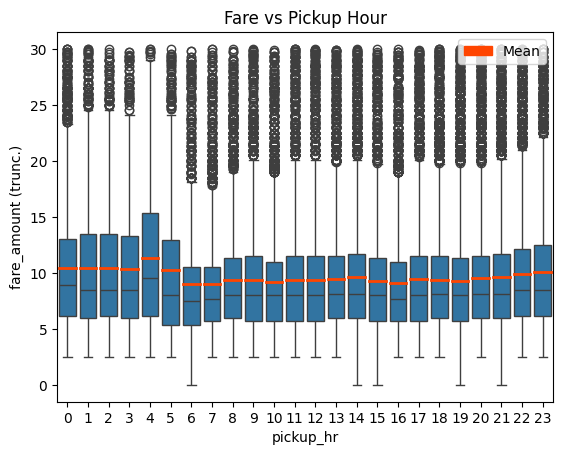

In [111]:
fare_hr_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_hr', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hr_box.set_ylabel(f'{fare_hr_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Pickup Day of Week')

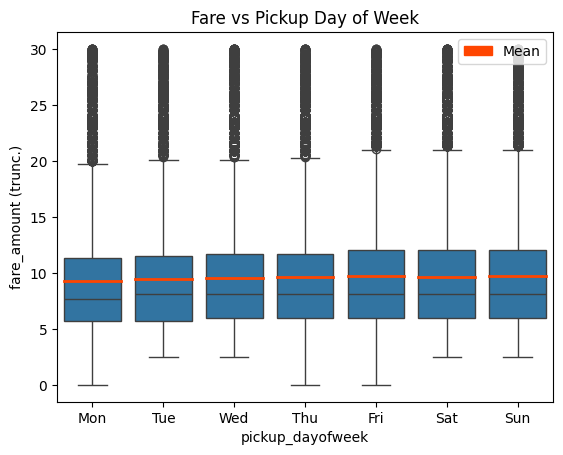

In [118]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Pickup Month')

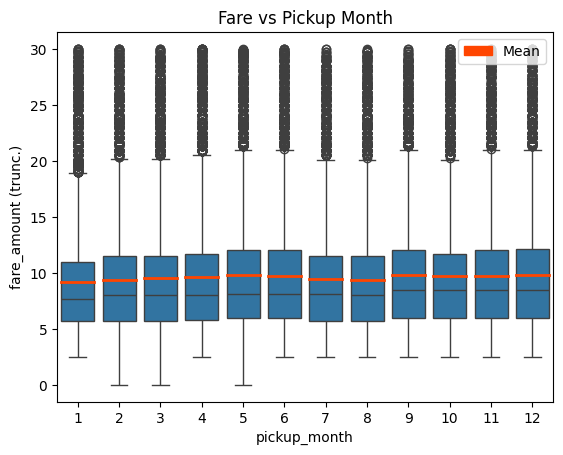

In [117]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Pickup Year')

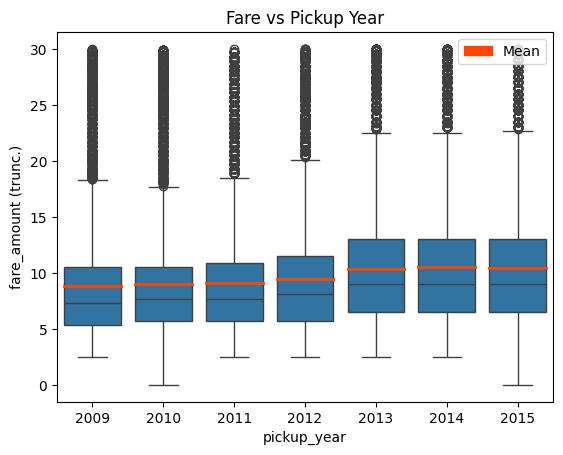

In [116]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Year')

### Location

<Axes: xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

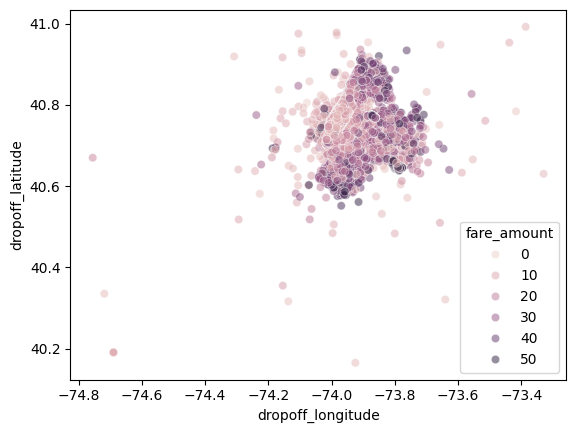

In [127]:
sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

0.0     12749
1.0     28417
2.0     12878
3.0      1073
4.0      2354
5.0      1224
6.0      2417
7.0         8
8.0       179
9.0     23385
10.0     2178
11.0     8139
Name: key, dtype: int64


[Text(0, 0, '11.3698'),
 Text(0, 0, '11.2895'),
 Text(0, 0, '11.3186'),
 Text(0, 0, '11.5462'),
 Text(0, 0, '11.2057'),
 Text(0, 0, '11.8734'),
 Text(0, 0, '11.3547'),
 Text(0, 0, '13.6463'),
 Text(0, 0, '10.6978'),
 Text(0, 0, '11.3298'),
 Text(0, 0, '11.4357'),
 Text(0, 0, '11.401')]

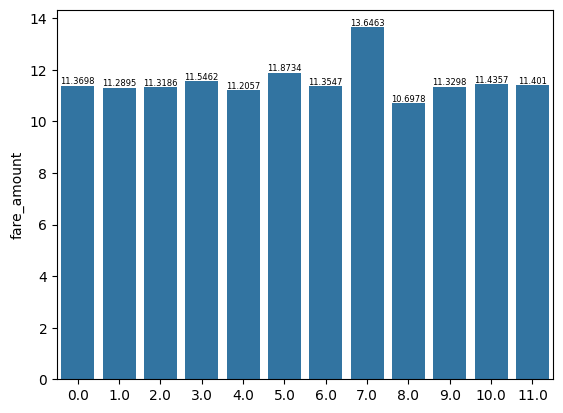

In [225]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
scaler = StandardScaler()
scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(12, n_init=20)
kmeans.fit(scaled_dropoff_locs)

clusters = pd.Series(kmeans.labels_)
cluster_fares = taxi.groupby(clusters)['fare_amount'].mean()
print(taxi.groupby(clusters)['key'].count())

ax = sns.barplot(cluster_fares)
ax.bar_label(ax.containers[0], fontsize=6)